#### Importing the data and req. modules

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
# visualization
from PIL import Image
# identifying faces
%pip install mtcnn
from mtcnn.mtcnn import MTCNN
# visualizing bounding boxes
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 8.2 MB/s 


In [2]:
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

In [3]:
!gdown --id 1U_A1Ybb6-6KUa51b_H01gpRRSF7K6LzT

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1U_A1Ybb6-6KUa51b_H01gpRRSF7K6LzT
To: /content/lfw.zip
100% 189M/189M [00:03<00:00, 56.2MB/s]


In [4]:
!unzip -q /content/lfw.zip

In [ ]:
dataset_path = "/content/lfw/"

In [ ]:
#upload lfw_allnames file from local storage
from google.colab import files
uploaded = files.upload()

ATTRIBUTES_PATH = "/content/lfw_allnames.csv"

Saving lfw_allnames.csv to lfw_allnames.csv


#### Understanding the dataset

In [ ]:
lfw_allnames = pd.read_csv(ATTRIBUTES_PATH)

In [ ]:
lfw_allnames.head()

,name,images
0,AJ_Cook,1
1,AJ_Lamas,1
2,Aaron_Eckhart,1
3,Aaron_Guiel,1
4,Aaron_Patterson,1


In [ ]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",1)


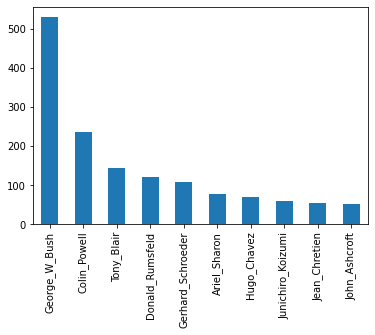

In [ ]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")

One of the drawbacks of the LFW dataset is that if has significant class imbalance. This can be dealt with using selective sampling, but it is useful to get an indication of the scale of the imbalance.

In [ ]:
ind_counts = image_paths.groupby('name').count().image_path
print(str(sum(ind_counts[ind_counts==1]))+" individuals have only single image")

4069 individuals have only single image


In [ ]:
image_paths['name'].value_counts()[:30]

George_W_Bush                530
Colin_Powell                 236
Tony_Blair                   144
Donald_Rumsfeld              121
Gerhard_Schroeder            109
Ariel_Sharon                  77
Hugo_Chavez                   71
Junichiro_Koizumi             60
Jean_Chretien                 55
John_Ashcroft                 53
Jacques_Chirac                52
Serena_Williams               52
Vladimir_Putin                49
Luiz_Inacio_Lula_da_Silva     48
Gloria_Macapagal_Arroyo       44
Arnold_Schwarzenegger         42
Jennifer_Capriati             42
Laura_Bush                    41
Lleyton_Hewitt                41
Alejandro_Toledo              39
Hans_Blix                     39
Nestor_Kirchner               37
Andre_Agassi                  36
Alvaro_Uribe                  35
Megawati_Sukarnoputri         33
Tom_Ridge                     33
Silvio_Berlusconi             33
Roh_Moo-hyun                  32
Kofi_Annan                    32
Vicente_Fox                   32
Name: name

This shows clr imbalance of the dataset. We could either upsample or downsample the datset

#### Creating the dataset

In [ ]:
image_paths.image_path[0]

'AJ_Cook/AJ_Cook_0001.jpg'

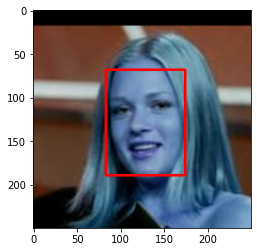

In [ ]:
# Use out-of-the-box MTCNN algorithm to identify facial boundaries on a sample image
detector = MTCNN()
image = cv2.imread(dataset_path+str(image_paths.image_path[0]))
result = detector.detect_faces(image)
# That's it - the results have already been generated! Now we extract the boundaries that have been identified 
x,y,w,h = result[0]['box']
keypoints = result[0]['keypoints']
# Finally, we plot the image along with the face's bounding box and internal features (eyes, nose, and mouth corners)
fig,ax = plt.subplots(1)
#ax.imshow(image)
cv2.rectangle(image,(x,y),(x+w, y+h), (255, 0, 0), 2)
ax.imshow(image)
plt.show()

In [ ]:
new_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"].sample(48),
                        image_paths[image_paths.name=="Colin_Powell"].sample(48),
                        image_paths[image_paths.name=="Tony_Blair"].sample(48),
                        image_paths[image_paths.name=="Donald_Rumsfeld"].sample(48),
                        image_paths[image_paths.name=="Gerhard_Schroeder"].sample(48),
                        image_paths[image_paths.name=="Ariel_Sharon"].sample(48),
                        image_paths[image_paths.name=="Hugo_Chavez"].sample(48),
                      image_paths[image_paths.name=="Junichiro_Koizumi"].sample(48),
                      image_paths[image_paths.name=="Jean_Chretien"].sample(48),
                      image_paths[image_paths.name=="John_Ashcroft"].sample(48),
                      image_paths[image_paths.name=="Serena_Williams"].sample(48),
                      image_paths[image_paths.name=="Jacques_Chirac"].sample(48),
                      image_paths[image_paths.name=="Vladimir_Putin"].sample(48),
                      image_paths[image_paths.name=="Luiz_Inacio_Lula_da_Silva"].sample(48),
                      #image_paths[image_paths.name=="Gloria_Macapagal_Arroyo"].sample(40)
                        ])

In [ ]:
print(new_data.head())
print(len(new_data))

               name                            image_path
1871  George_W_Bush  George_W_Bush/George_W_Bush_0099.jpg
1871  George_W_Bush  George_W_Bush/George_W_Bush_0506.jpg
1871  George_W_Bush  George_W_Bush/George_W_Bush_0419.jpg
1871  George_W_Bush  George_W_Bush/George_W_Bush_0353.jpg
1871  George_W_Bush  George_W_Bush/George_W_Bush_0124.jpg
672


In [ ]:
def detect_crop(img_path,loc):
    detector = MTCNN()
    image = cv2.imread(img_path)
    result = detector.detect_faces(image)
    try:
      x,y,w,h = result[0]['box']
      cropped = image[y:y+h,x:x+w]
      os.chdir(loc)
      name = img_path.split("/")[-1]
      #print(os.curdir)
      #print("NAME: ",name)
      cv2.imwrite(name,cropped)
    except:
      pass

In [ ]:
train, test = train_test_split(new_data, test_size=0.2)
train, val = train_test_split(train,test_size=0.2)

In [ ]:
def directory_mover(data,dir_name):
    co = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join('/content/',dir_name)):
            shutil.os.mkdir(os.path.join('/content/',dir_name))
        
        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('/content/',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('/content/',dir_name,data_type))
        path_from = os.path.join(dataset_path,image)
        path_to = os.path.join('/content/',dir_name,data_type)
        # print(path_to)
        #print(path_to,path_from)
        detect_crop(path_from,path_to)
        
        #shutil.copy(path_from, path_to)
        co += 1
        
    print('Moved {} images to {} folder.'.format(co,dir_name))

In [ ]:
directory_mover(train,"train_data/")
directory_mover(val,"val_data/")
directory_mover(test,"test_data/")

Moved 429 images to train_data/ folder.
Moved 108 images to val_data/ folder.
Moved 135 images to test_data/ folder.


In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/train_data/', target_size = (150, 150), batch_size = 32, class_mode = 'categorical')
val_set = test_datagen.flow_from_directory('/content/val_data/', target_size = (150, 150), batch_size = 32, class_mode = 'categorical')
test_set = test_datagen.flow_from_directory('/content/test_data/', target_size = (150, 150), batch_size = 32, class_mode = 'categorical')

Found 416 images belonging to 14 classes.
Found 104 images belonging to 14 classes.
Found 128 images belonging to 14 classes.


####CREATING AND TRAINING THE MODEL

In [ ]:
# initialize sequential network
from keras.models import Sequential
# include convolutional layers
from keras.layers import Conv2D
# Pooling layers
from keras.layers import MaxPooling2D
# flatten layers into single vector
from keras.layers import Flatten
from keras.layers import Dense

#####MODEL1 - 67%

In [ ]:
# Same model setup as before
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Flatten())

classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 14, activation = 'softmax'))

print(classifier.summary())
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8112 (Conv2D)         (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d_4056 (MaxPooli (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_8113 (Conv2D)         (None, 122, 122, 32)      9248      
_________________________________________________________________
max_pooling2d_4057 (MaxPooli (None, 61, 61, 32)        0         
_________________________________________________________________
flatten_1352 (Flatten)       (None, 119072)            0         
_________________________________________________________________
dense_4732 (Dense)           (None, 128)               15241344  
_________________________________________________________________
dense_4733 (Dense)           (None, 14)                1

In [ ]:
history = classifier.fit_generator(training_set, epochs = 50, validation_data = val_set)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
13/13 [==============================] - 29s 2s/step - loss: 5.6758 - accuracy: 0.0796 - val_loss: 2.6540 - val_accuracy: 0.0952
Epoch 2/50
13/13 [==============================] - 28s 2s/step - loss: 2.6266 - accuracy: 0.0860 - val_loss: 2.6134 - val_accuracy: 0.0762
Epoch 3/50
13/13 [==============================] - 28s 2s/step - loss: 2.5445 - accuracy: 0.1586 - val_loss: 2.4601 - val_accuracy: 0.2095
Epoch 4/50
13/13 [==============================] - 28s 2s/step - loss: 2.2868 - accuracy: 0.2293 - val_loss: 2.2089 - val_accuracy: 0.3429
Epoch 5/50
13/13 [==============================] - 28s 2s/step - loss: 2.0882 - accuracy: 0.3098 - val_loss: 2.0270 - val_accuracy: 0.3524
Epoch 6/50
13/13 [==============================] - 28s 2s/step - loss: 1.8315 - accuracy: 0.4786 - val_loss: 1.8501 - val_accuracy: 0.4190
Epoch 7/50
13/13 [==============================] - 28s 2s/step - loss: 1.6024 - accuracy: 0.5114 - val_loss: 1.7846 - val_accuracy: 0.4571
Epoch 8/50
13/13 [==

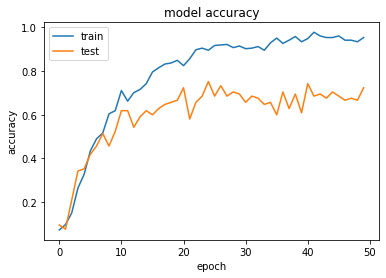

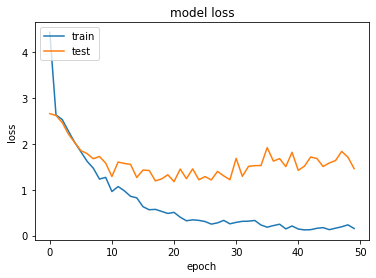

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = classifier.evaluate(test_set, verbose=1)
print("LOSS: ",loss)
print("ACCURACY: ",accuracy)

5/5 [==============================] - 2s 396ms/step - loss: 1.4113 - accuracy: 0.6744
LOSS:  1.4112910032272339
ACCURACY:  0.6744186282157898


##### Model2 - 72%

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(units = 256,activation='relu'))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 14, activation = 'softmax'))

print(model.summary())

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8117 (Conv2D)         (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d_4061 (MaxPooli (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_8118 (Conv2D)         (None, 122, 122, 32)      9248      
_________________________________________________________________
max_pooling2d_4062 (MaxPooli (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_8119 (Conv2D)         (None, 59, 59, 64)        18496     
_________________________________________________________________
max_pooling2d_4063 (MaxPooli (None, 29, 29, 64)        0         
_________________________________________________________________
flatten_1354 (Flatten)       (None, 53824)            

In [ ]:
history1 = model.fit_generator(training_set, epochs = 50, validation_data = val_set)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
13/13 [==============================] - 39s 3s/step - loss: 2.6772 - accuracy: 0.0387 - val_loss: 2.6645 - val_accuracy: 0.0381
Epoch 2/50
13/13 [==============================] - 34s 2s/step - loss: 2.6226 - accuracy: 0.1404 - val_loss: 2.6562 - val_accuracy: 0.0190
Epoch 3/50
13/13 [==============================] - 33s 2s/step - loss: 2.6334 - accuracy: 0.0685 - val_loss: 2.6512 - val_accuracy: 0.0381
Epoch 4/50
13/13 [==============================] - 33s 3s/step - loss: 2.5660 - accuracy: 0.1377 - val_loss: 2.5657 - val_accuracy: 0.1429
Epoch 5/50
13/13 [==============================] - 33s 2s/step - loss: 2.3885 - accuracy: 0.2332 - val_loss: 2.3047 - val_accuracy: 0.2571
Epoch 6/50
13/13 [==============================] - 33s 2s/step - loss: 2.2966 - accuracy: 0.2287 - val_loss: 2.3494 - val_accuracy: 0.1905
Epoch 7/50
13/13 [==============================] - 33s 2s/step - loss: 2.0969 - accuracy: 0.2950 - val_loss: 2.2388 - val_accuracy: 0.2571
Epoch 8/50
13/13 [==

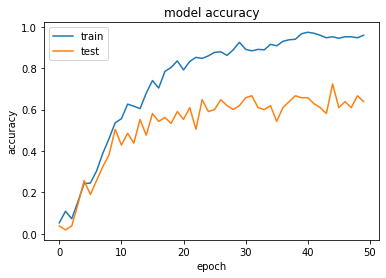

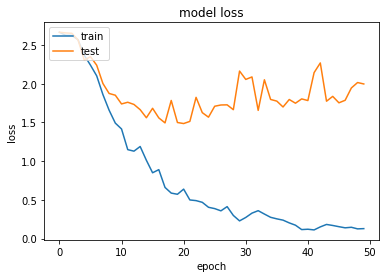

In [ ]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_set, verbose=1)
print("LOSS: ",loss)
print("ACCURACY: ",accuracy)

5/5 [==============================] - 3s 468ms/step - loss: 1.9333 - accuracy: 0.6512
LOSS:  1.9333492517471313
ACCURACY:  0.6511628031730652


##### Model 3 - 60%
Note that removal of conv layers decreases accuracy

In [ ]:
from keras.layers import Dropout

model3 = Sequential()
model3.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))
model3.add(MaxPooling2D(pool_size = (2, 2)))

model3.add(Conv2D(64, (3, 3), activation = 'relu'))
model3.add(MaxPooling2D(pool_size = (2, 2)))

model3.add(Flatten())

model3.add(Dense(units = 256,activation="relu"))
model3.add(Dropout(0.2))
model3.add(Dense(units = 256,activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(units = 128, activation = 'relu'))
model3.add(Dense(units = 14, activation = 'softmax'))

print(model3.summary())

model3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8132 (Conv2D)         (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d_4076 (MaxPooli (None, 124, 124, 32)      0         
_________________________________________________________________
flatten_1359 (Flatten)       (None, 492032)            0         
_________________________________________________________________
dense_4753 (Dense)           (None, 256)               125960448 
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_4754 (Dense)           (None, 256)               65792     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)              

In [ ]:
#from keras.callbacks import EarlyStopping
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience= 10) #obtained only 60% on val data and 55% on test data
history3 = model3.fit_generator(training_set, epochs = 60, validation_data = val_set)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
13/13 [==============================] - 34s 2s/step - loss: 26.8629 - accuracy: 0.0460 - val_loss: 3.3861 - val_accuracy: 0.0571
Epoch 2/60
13/13 [==============================] - 32s 2s/step - loss: 3.9997 - accuracy: 0.0803 - val_loss: 2.6299 - val_accuracy: 0.0667
Epoch 3/60
13/13 [==============================] - 27s 2s/step - loss: 2.6843 - accuracy: 0.0535 - val_loss: 2.6535 - val_accuracy: 0.0571
Epoch 4/60
13/13 [==============================] - 27s 2s/step - loss: 2.6420 - accuracy: 0.0619 - val_loss: 2.6432 - val_accuracy: 0.0381
Epoch 5/60
13/13 [==============================] - 27s 2s/step - loss: 2.6410 - accuracy: 0.0832 - val_loss: 2.6432 - val_accuracy: 0.0381
Epoch 6/60
13/13 [==============================] - 27s 2s/step - loss: 2.6389 - accuracy: 0.0860 - val_loss: 2.6382 - val_accuracy: 0.0381
Epoch 7/60
13/13 [==============================] - 27s 2s/step - loss: 2.6360 - accuracy: 0.0782 - val_loss: 2.6428 - val_accuracy: 0.0381
Epoch 8/60
13/13 [=

KeyboardInterrupt: ignored

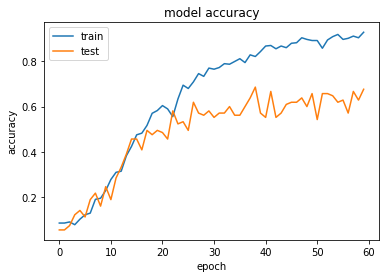

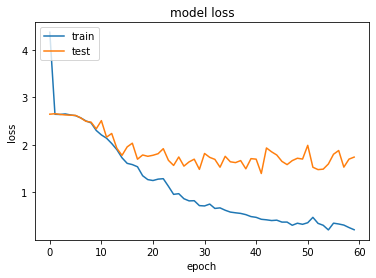

In [ ]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model3.evaluate(test_set, verbose=1)
print("LOSS: ",loss)
print("ACCURACY: ",accuracy)

5/5 [==============================] - 3s 551ms/step - loss: 1.5814 - accuracy: 0.6047
LOSS:  1.5813555717468262
ACCURACY:  0.604651153087616


##### Model4 using transfer learning - 94.5% accuracy

In [ ]:
from keras.layers import BatchNormalization, Conv2D,Flatten,MaxPooling2D,Dropout
from keras import regularizers
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau

In [ ]:
from keras.applications.vgg19 import VGG19

lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5)
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = (150,150,3), classes = 14)

In [ ]:
model4= Sequential()
model4.add(base_model) 
model4.add(Flatten()) 

model4.add(Dense(1024,activation=('relu')))
model4.add(Dense(512,activation=('relu'))) 
model4.add(Dense(256,activation=('relu'))) 
model4.add(Dropout(.3))
model4.add(Dense(128,activation=('relu')))
#model.add(Dropout(.2))
model4.add(Dense(14,activation=('softmax'))) 

#Checking the final model summary
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1349 (Flatten)       (None, 8192)              0         
_________________________________________________________________
dense_4720 (Dense)           (None, 1024)              8389632   
_________________________________________________________________
dense_4721 (Dense)           (None, 512)               524800    
_________________________________________________________________
dense_4722 (Dense)           (None, 256)               131328    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4723 (Dense)           (None, 128)              

In [ ]:
batch_size= 100
epochs=50
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model4.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history4 = model4.fit(training_set,epochs = epochs, validation_data = val_set, callbacks=[lrr], verbose = 1)

Epoch 1/50
13/13 [==============================] - 17s 824ms/step - loss: 2.7001 - accuracy: 0.0490 - val_loss: 2.6631 - val_accuracy: 0.0495
Epoch 2/50
13/13 [==============================] - 4s 290ms/step - loss: 2.6413 - accuracy: 0.1083 - val_loss: 2.6242 - val_accuracy: 0.1485
Epoch 3/50
13/13 [==============================] - 4s 277ms/step - loss: 2.6128 - accuracy: 0.0946 - val_loss: 2.6005 - val_accuracy: 0.0693
Epoch 4/50
13/13 [==============================] - 4s 279ms/step - loss: 2.5581 - accuracy: 0.1424 - val_loss: 2.5002 - val_accuracy: 0.1782
Epoch 5/50
13/13 [==============================] - 4s 280ms/step - loss: 2.4785 - accuracy: 0.2035 - val_loss: 2.3476 - val_accuracy: 0.2871
Epoch 6/50
13/13 [==============================] - 4s 280ms/step - loss: 2.2876 - accuracy: 0.2550 - val_loss: 2.1526 - val_accuracy: 0.3366
Epoch 7/50
13/13 [==============================] - 4s 282ms/step - loss: 2.2012 - accuracy: 0.2686 - val_loss: 1.9917 - val_accuracy: 0.3762
Epoch

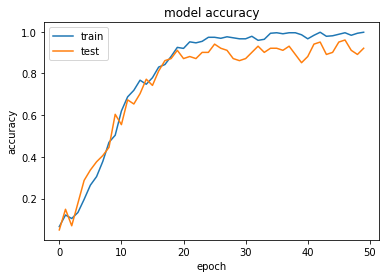

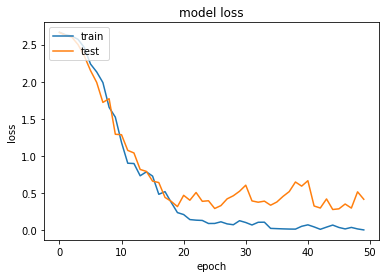

In [ ]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model4.evaluate(test_set, verbose=1)
print("LOSS: ",loss)
print("ACCURACY: ",accuracy)

5/5 [==============================] - 1s 211ms/step - loss: 0.2544 - accuracy: 0.9457
LOSS:  0.2543565034866333
ACCURACY:  0.9457364082336426


In [ ]:
!mkdir -p saved_model
model4.save('saved_model/best_model')

In [ ]:
#!ls saved_model
!ls saved_model/best_model

assets	saved_model.pb	variables


In [ ]:
model_json = model4.to_json()
#with open("/content/lfw_model.json","w") as json_file:
#    json_file.write(model_json)
model4.save_weights("/content/lfw_model.h5")

##### Model5 with 88% accuracy 

In [ ]:
model5= Sequential()
model5.add(base_model) 
model5.add(Flatten()) 

model5.add(Dense(1024,activation=('relu')))
model5.add(Dense(512,activation=('relu'))) 
model5.add(Dense(256,activation=('relu')))
model5.add(Dense(256,activation=('relu'))) 
model5.add(Dropout(.3))
model5.add(Dense(128,activation=('relu')))
#model.add(Dropout(.2))
model5.add(Dense(14,activation=('softmax'))) 

#Checking the final model summary
model5.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1347 (Flatten)       (None, 25088)             0         
_________________________________________________________________
dense_4716 (Dense)           (None, 1024)              25691136  
_________________________________________________________________
dense_4717 (Dense)           (None, 512)               524800    
_________________________________________________________________
dense_4718 (Dense)           (None, 256)               131328    
_________________________________________________________________
dense_4719 (Dense)           (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

In [ ]:
batch_size= 100
epochs=50
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model5.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history5 = model5.fit(training_set,epochs = epochs, validation_data = val_set, callbacks=[lrr], verbose = 1)

Epoch 1/50
13/13 [==============================] - 38s 2s/step - loss: 2.6812 - accuracy: 0.0620 - val_loss: 2.6421 - val_accuracy: 0.0762
Epoch 2/50
13/13 [==============================] - 10s 718ms/step - loss: 2.6477 - accuracy: 0.0906 - val_loss: 2.6609 - val_accuracy: 0.0381
Epoch 3/50
13/13 [==============================] - 9s 709ms/step - loss: 2.6513 - accuracy: 0.0645 - val_loss: 2.6656 - val_accuracy: 0.0381
Epoch 4/50
13/13 [==============================] - 9s 706ms/step - loss: 2.6375 - accuracy: 0.0688 - val_loss: 2.6507 - val_accuracy: 0.0857
Epoch 5/50
13/13 [==============================] - 9s 704ms/step - loss: 2.6320 - accuracy: 0.0824 - val_loss: 2.6413 - val_accuracy: 0.0571
Epoch 6/50
13/13 [==============================] - 9s 711ms/step - loss: 2.6165 - accuracy: 0.0868 - val_loss: 2.6172 - val_accuracy: 0.1048
Epoch 7/50
13/13 [==============================] - 9s 701ms/step - loss: 2.5824 - accuracy: 0.1250 - val_loss: 2.5852 - val_accuracy: 0.1238
Epoch 8

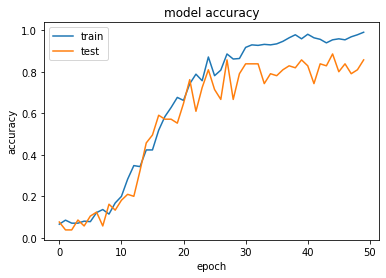

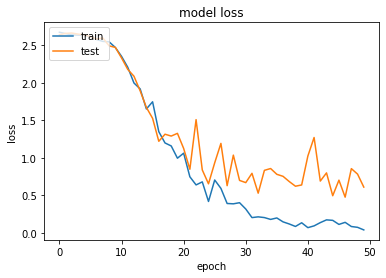

In [ ]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model5.evaluate(test_set, verbose=1)
print("LOSS: ",loss)
print("ACCURACY: ",accuracy)

4/4 [==============================] - 8s 3s/step - loss: 0.3454 - accuracy: 0.8819
LOSS:  0.34539759159088135
ACCURACY:  0.8818897604942322


In [ ]:
model5.save('/content/my_model.h5')

#####Model 6 - 56% accuracy

In [ ]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

input_shape = (150,150,3)

model6 = Sequential()

model6.add(Conv2D(16, kernel_size=(3, 3),
                  activation='relu',
                  kernel_regularizer=regularizers.l2(0.),
                  activity_regularizer=regularizers.l2(0.),
                  input_shape=input_shape))

model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(BatchNormalization())
model6.add(Dropout(0.25))

model6.add(Conv2D(32, kernel_size=(3, 3),
                  activation='relu',
                  kernel_regularizer=regularizers.l2(0.),
                  activity_regularizer=regularizers.l2(0.)))

model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(BatchNormalization())
model6.add(Dropout(0.25))

model6.add(Flatten())

model6.add(Dense(3000, activation='relu',
                kernel_regularizer=regularizers.l2(0.),
                activity_regularizer=regularizers.l2(0.)))

model6.add(Dropout(0.25))
model6.add(Dense(14, activation='softmax'))

model6.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8086 (Conv2D)         (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_4048 (MaxPooli (None, 74, 74, 16)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 74, 74, 16)        64        
_________________________________________________________________
dropout_17 (Dropout)         (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_8087 (Conv2D)         (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4049 (MaxPooli (None, 36, 36, 32)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 36, 36, 32)       

In [ ]:
model6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history6 = model6.fit(training_set,epochs = 60, validation_data = val_set, verbose = 1)

Epoch 1/60
13/13 [==============================] - 4s 202ms/step - loss: 32.3490 - accuracy: 0.1616 - val_loss: 6.0592 - val_accuracy: 0.1089
Epoch 2/60
13/13 [==============================] - 2s 185ms/step - loss: 10.3486 - accuracy: 0.4238 - val_loss: 6.8263 - val_accuracy: 0.0594
Epoch 3/60
13/13 [==============================] - 2s 182ms/step - loss: 6.0348 - accuracy: 0.5056 - val_loss: 7.8001 - val_accuracy: 0.0594
Epoch 4/60
13/13 [==============================] - 2s 183ms/step - loss: 3.4619 - accuracy: 0.6369 - val_loss: 7.3744 - val_accuracy: 0.0495
Epoch 5/60
13/13 [==============================] - 2s 182ms/step - loss: 2.7936 - accuracy: 0.6703 - val_loss: 10.1743 - val_accuracy: 0.0594
Epoch 6/60
13/13 [==============================] - 2s 181ms/step - loss: 1.9018 - accuracy: 0.7710 - val_loss: 20.6547 - val_accuracy: 0.0495
Epoch 7/60
13/13 [==============================] - 2s 182ms/step - loss: 1.7082 - accuracy: 0.7612 - val_loss: 13.3614 - val_accuracy: 0.1089
E

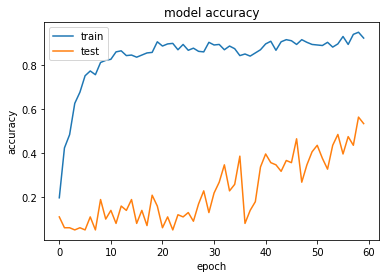

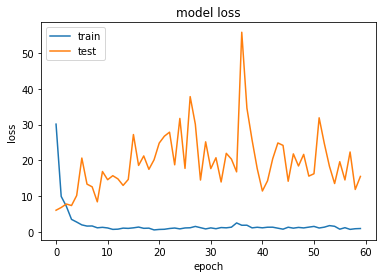

In [ ]:
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model6.evaluate(test_set, verbose=1)
print("LOSS: ",loss)
print("ACCURACY: ",accuracy)

5/5 [==============================] - 0s 35ms/step - loss: 13.9718 - accuracy: 0.5659
LOSS:  13.97181510925293
ACCURACY:  0.565891444683075
